# Siamese CNN & OCSVM


**Description**   

Reimplemenation of an approach to Continuous Authentication described by [1]. It leverages a Siamese CNN to generate Deep Features, which are then used as input for an OCSVM authentication classifier.  

**Purpose**

- Verify results of [1]
- Test the approach with upfront global subject wise normalization (NAIVE_APPROACH)
- Change the normalization setting to be more realistic: Training data is normalized upfront again, but the Testing data is normalized using a single scaler fitted on training data only. (VALID_APPROACH)
- Identify parameters performing better in a valid setup than the parameters proposed by [1]. (ALTERNATIVE_APPROACH) 

**Data Sources**   

- [H-MOG Dataset](http://www.cs.wm.edu/~qyang/hmog.html)  
  (Downloaded beforehand using  [./src/data/make_dataset.py](./src/data/make_dataset.py), stored in [./data/external/hmog_dataset/](./data/external/hmog_dataset/) and converted to [./data/processed/hmog_dataset.hdf5](./data/processed/hmog_dataset.hdf5))

**References**   

- [1] Centeno, M. P. et al. (2018): Mobile Based Continuous Authentication Using Deep Features. Proceedings of the 2^nd International Workshop on Embedded and Mobile Deep Learning (EMDL), 2018, 19-24.

**Table of Contents**

**1 - [Preparations](#1)**   
1.1 - [Imports](#1.1)   
1.2 - [Configuration](#1.2)   
1.3 - [Experiment Parameters](#1.3)   
1.4 - [Select Approach](#1.4)   

**2 - [Initial Data Prepratation](#2)**   
2.1 - [Load Dataset](#2.1)   
2.2 - [Normalize Features (if global)](#2.2)   
2.3 - [Split Dataset for Valid/Test](#2.3)   
2.4 - [Normalize Features (if not global)](#2.4)   
2.5 - [Check Splits](#2.5)   
2.6 - [Reshape Features](#2.6)     

**3 - [Generate Scenario Pairs](#3)**    
3.1 - [Load cached Data](#3.1)  
3.2 - [Build positive/negative Pairs](#3.2)  
3.3 - [Inspect Pairs](#3.3)  
3.4 - [Cache Pairs](#3.4)  

**4 - [Siamese Network](#4)**  
4.1 - [Load cached Pairs](#4.1)   
4.2 - [Build Model](#4.2)   
4.3 - [Prepare Features](#4.3)   
4.4 - [Search optimal Epoch](#4.4)   
4.5 - [Check Distances](#4.5)   
4.6 - [Rebuild and train to optimal Epoch](#4.6)   
4.7 - [Cache Model](#4.7)   

**5 - [Visualize Deep Features](#5)**   
5.1 - [Load cached Data](#5.1)  
5.2 - [Extract CNN from Siamese Model](#5.2)  
5.3 - [Test Generation of Deep Features](#5.3)  
5.4 - [Visualize in 2D using PCA](#5.4)  

**6 - [OCSVM](#6)**  
6.1 - [Load cached Data](#6.1)  
6.2 - [Load trained Siamese Model](#6.2)  
6.3 - [Search for Parameters](#6.3)  
6.4 - [Inspect Search Results](#6.4) 

**7 - [Testing](#7)**  
7.1 - [Load cached Data](#7.1)  
7.2 - [Evaluate Auth Performance](#7.2)  
7.3 - [Evaluate increasing Training Set Size (Training Delay)](#7.3)  
7.4 - [Evaluate increasing Test Set Sizes (Detection Delay)](#7.4)  

**8 - [Report Results](#8)**  

## 1. Preparations <a id='1'>&nbsp;</a> 

### 1.1 Imports <a id='1.1'>&nbsp;</a> 
**Note:** The custom `DatasetLoader` is a helper class for easier loading and subsetting data from the datasets.

In [49]:
import dill
dill.load_session('55.db')
#dill.dump_session('55.db')

AttributeError: module 'dill' has no attribute 'load_session'

In [2]:
import scipy as sc 
print(sc.__version__)

1.4.1


tflow_select-2.3.0-mkl
blas-1.0-mkl
ca-certificates-2019.5.15-0
icc_rt-2019.0.0-h0cc432a_1
intel-openmp-2019.4-245
msys2-conda-epoch-20160418-1
pandoc-2.2.3.2-0
vs2015_runtime-14.15.26706-h3a45250_4
winpty-0.4.3-4
libmklml-2019.0.3-0
m2w64-gmp-6.1.0-2
m2w64-libwinpthread-git-5.0.0.4634.697f757-2
mkl-2019.4-245
nodejs-10.13.0-0
vc-14.1-h0510ff6_4
bzip2-1.0.6-hfa6e2cd_5
ffmpeg-4.1.3-h6538335_0
graphviz-2.38-hfd603c8_2
icu-58.2-ha66f8fd_1
jpeg-9b-hb83a4c4_2
libsodium-1.0.16-h9d3ae62_0
lz4-c-1.8.1.2-h2fa13f4_0
lzo-2.10-h6df0209_2
m2w64-gcc-libs-core-5.3.0-7
openssl-1.1.1c-he774522_1
snappy-1.1.7-h777316e_3
sqlite-3.28.0-he774522_0
xz-5.2.4-h2fa13f4_4
yaml-0.1.7-hc54c509_2
zlib-1.2.11-h62dcd97_3
hdf5-1.10.4-h7ebc959_0
libpng-1.6.37-h2a8f88b_0
libprotobuf-3.8.0-h7bd577a_0
m2w64-gcc-libgfortran-5.3.0-6
python-3.6.8-h9f7ef89_7
zeromq-4.3.1-h33f27b4_3
zstd-1.3.7-h508b16e_0
appdirs-1.4.3-py36h28b3542_0
astor-0.7.1-py36_0
attrs-19.1.0-py36_1
backcall-0.1.0-py36_0
blosc-1.16.3-h7bd577a_0
certifi-2019.6.16-py36_0
click-7.0-py36_0
colorama-0.4.1-py36_0
dataclasses-0.6-py_0
decorator-4.4.0-py36_1
defusedxml-0.6.0-py_0
entrypoints-0.3-py36_0
freetype-2.9.1-ha9979f8_1
gast-0.2.2-py36_0
ipython_genutils-0.2.0-py36h3c5d0ee_0
joblib-0.13.2-py36_0
kiwisolver-1.1.0-py36ha925a31_0
lazy-object-proxy-1.4.1-py36he774522_0
m2w64-gcc-libs-5.3.0-7
markupsafe-1.1.1-py36he774522_0
mccabe-0.6.1-py36_1
mistune-0.8.4-py36he774522_0
numpy-base-1.16.4-py36hc3f5095_0
pandocfilters-1.4.2-py36_1
parso-0.4.0-py_0
pickleshare-0.7.5-py36_0
prometheus_client-0.6.0-py36_0
pycodestyle-2.5.0-py36_0
pyflakes-2.1.1-py36_0
pyparsing-2.4.0-py_0
pyreadline-2.1-py36_1
pytz-2019.1-py_0
pyyaml-5.1-py36he774522_0
pyzmq-18.0.0-py36ha925a31_0
qt-5.9.7-vc14h73c81de_0
send2trash-1.5.0-py36_0
sip-4.19.8-py36h6538335_0
six-1.12.0-py36_0
snowballstemmer-1.2.1-py36h763602f_0
termcolor-1.1.0-py36_1
testpath-0.4.2-py36_0
toml-0.10.0-py36h28b3542_0
tornado-6.0.2-py36he774522_0
tqdm-4.31.1-py36_1
typed-ast-1.3.4-py36he774522_0
wcwidth-0.1.7-py36h3d5aa90_0
webencodings-0.5.1-py36_1
werkzeug-0.15.4-py_0
wincertstore-0.2-py36h7fe50ca_0
wrapt-1.11.1-py36he774522_0
absl-py-0.7.1-py36_0
black-19.3b0-py_0
cycler-0.10.0-py36h009560c_0
jedi-0.13.3-py36_0
mkl_random-1.0.2-py36h343c172_0
mock-3.0.5-py36_0
pydocstyle-3.0.0-py36_0
pydot-1.4.1-py36_0
pyqt-5.9.2-py36h6538335_2
pyrsistent-0.14.11-py36he774522_0
python-dateutil-2.8.0-py36_0
pywinpty-0.5.5-py36_1000
setuptools-41.0.1-py36_0
traitlets-4.3.2-py36h096827d_0
astroid-2.2.5-py36_0
bleach-3.1.0-py36_0
flake8-3.7.7-py36_0
grpcio-1.16.1-py36h351948d_1
isort-4.3.20-py36_0
jinja2-2.10.1-py36_0
jsonschema-3.0.1-py36_0
jupyter_core-4.4.0-py36_0
markdown-3.1.1-py36_0
protobuf-3.8.0-py36h33f27b4_0
pygments-2.4.2-py_0
terminado-0.8.2-py36_0
wheel-0.33.4-py36_0
jupyter_client-5.2.4-py36_0
nbformat-4.4.0-py36h3a5bc1b_0
pip-19.1.1-py36_0
prompt_toolkit-2.0.9-py36_0
pylint-2.3.1-py36_0
ipython-7.5.0-py36h39e3cac_0
nbconvert-5.5.0-py_0
ipykernel-5.1.1-py36h39e3cac_0
notebook-5.7.8-py36_0
jupyterlab_server-0.2.0-py36_0
widgetsnbextension-3.4.2-py36_0
ipywidgets-7.4.2-py36_0
jupyterlab-0.35.4-py36hf63ae98_0
h5py-2.9.0-py36h5e291fa_0
keras-applications-1.0.8-py_0
matplotlib-3.0.3-py36hc8f65d3_0
mkl-service-2.0.2-py36he774522_0
mkl_fft-1.0.12-py36h14836fe_0
numpy-1.16.4-py36h19fb1c0_0
numexpr-2.6.9-py36hdce8814_0
pandas-0.24.2-py36ha925a31_0
scipy-1.2.1-py36h29ff71c_0
tensorboard-1.13.1-py36h33f27b4_0
tensorflow-estimator-1.13.0-py_0
keras-preprocessing-1.1.0-py_1
patsy-0.5.1-py36_0
peakutils-1.3.2-py_0
pytables-3.5.2-py36h1da0976_1
scikit-learn-0.21.2-py36h6288b17_0
keras-base-2.2.4-py36_0
statsmodels-0.9.0-py36h452e1ab_0
tensorflow-base-1.13.1-mkl_py36hcaf7020_0
seaborn-0.9.0-py36_0
tensorflow-1.13.1-mkl_py36hd212fbe_0
keras-2.2.4-0

In [2]:
#!pip uninstall numpy --y

'''
!pip install --user dataclasses==0.6
!pip install --user hdf5==1.10.4
!pip install --user h5py==2.9.0
!pip install --user keras-applications==1.0.8
!pip install --user matplotlib==3.0.3
!pip install --user mkl-service==2.0.2
!pip install --user mkl_fft==1.0.12
!pip install --user numpy==1.16.4
!pip install --user numexpr==2.6.9
!pip install --user pandas-0.24.2
!pip install --user scipy-1.2.1
!pip install --user tensorboard-1.13.1
!pip install --user tensorflow-estimator==1.13.0
!pip install --user keras-preprocessing==1.1.0
!pip install --user patsy==0.5.1
!pip install --user peakutils==1.3.2
!pip install --user pytables==3.5.2
!pip install --user scikit-learn==0.21.2
!pip install --user keras-base==2.2.4
!pip install --user statsmodels==0.9.0
!pip install --user tensorflow-base==1.13.1
!pip install --user seaborn==0.9.0
!pip install --user tensorflow==1.13.1
!pip install --user keras==2.2.4
!pip install --user numpy-base==1.16.4
!pip install --user tqdm==4.31.1

!pip install --user absl-py==0.7.1
!pip install --user gast==0.2.2
'''



!pip install --user tflow_select==2.3.0
!pip install --user blas==1.0
!pip install --user ca-certificates==2019.5.15
!pip install --user icc_rt==2019.0.0
!pip install --user intel-openmp==2019.4
!pip install --user epoch==20160418
!pip install --user pandoc==2.2.3.2
!pip install --user vs2015_runtime==14.15.26706
!pip install --user winpty==0.4.3
!pip install --user libmklml==2019.0.3
!pip install --user m2w64==gmp==6.1.0
!pip install --user m2w64==libwinpthread
!pip install --user mkl==2019.4
!pip install --user nodejs==10.13.0
!pip install --user vc==14.1
!pip install --user bzip2==1.0.6
!pip install --user ffmpeg==4.1.3
!pip install --user graphviz==2.38
!pip install --user icu==58.2
!pip install --user jpeg==9b
!pip install --user libsodium==1.0.16
!pip install --user lz4==c==1.8.1.2
!pip install --user lzo==2.10
!pip install --user m2w64-gcc-libs-core==5.3.0
!pip install --user openssl==1.1.1c
!pip install --user snappy==1.1.7
!pip install --user sqlite==3.28.0
!pip install --user xz==5.2.4
!pip install --user yaml==0.1.7
!pip install --user zlib==1.2.11
!pip install --user libpng==1.6.37
!pip install --user libprotobuf==3.8.0
!pip install --user m2w64-gcc-libgfortran==5.3.0
!pip install --user python==3.6.8
!pip install --user zeromq==4.3.1
!pip install --user zstd==1.3.7
!pip install --user appdirs==1.4.3
!pip install --user astor==0.7.1
!pip install --user attrs==19.1.0
!pip install --user backcall==0.1.0
!pip install --user blosc==1.16.3
!pip install --user certifi==2019.6.16
!pip install --user click==7.0
!pip install --user colorama==0.4.1

!pip install --user decorator==4.4.0
!pip install --user defusedxml==0.6.0
!pip install --user entrypoints==0.3
!pip install --user freetype==2.9.1

!pip install --user ipython_genutils==0.2.0
!pip install --user joblib==0.13.2
!pip install --user kiwisolver==1.1.0
!pip install --user lazy-object-proxy==1.4.1
!pip install --user m2w64-gcc-libs==5.3.0
!pip install --user markupsafe==1.1.1
!pip install --user mccabe==0.6.1
!pip install --user mistune==0.8.4
!pip install --user pandocfilters==1.4.2
!pip install --user parso==0.4.0
!pip install --user pickleshare==0.7.5
!pip install --user prometheus_client==0.6.0
!pip install --user pycodestyle==2.5.0
!pip install --user pyflakes==2.1.1
!pip install --user pyparsing==2.4.0
!pip install --user pyreadline==2.1
!pip install --user pytz==2019.1
!pip install --user pyyaml==5.1
!pip install --user pyzmq==18.0.0
!pip install --user qt==5.9.7==vc14h73c81de_0
!pip install --user send2trash==1.5.0
!pip install --user sip==4.19.8
!pip install --user six==1.12.0
!pip install --user snowballstemmer==1.2.1
!pip install --user termcolor==1.1.0
!pip install --user testpath==0.4.2
!pip install --user toml==0.10.0
!pip install --user tornado==6.0.2
!pip install --user typed==ast==1.3.4
!pip install --user wcwidth==0.1.7
!pip install --user webencodings==0.5.1
!pip install --user werkzeug==0.15.4
!pip install --user wincertstore==0.2
!pip install --user wrapt==1.11.1
!pip install --user black==19.3b0
!pip install --user cycler==0.10.0
!pip install --user jedi==0.13.3
!pip install --user mkl_random==1.0.2
!pip install --user mock==3.0.5
!pip install --user pydocstyle==3.0.0
!pip install --user pydot==1.4.1
!pip install --user pyqt==5.9.2
!pip install --user pyrsistent==0.14.11
!pip install --user python==dateutil==2.8.0
!pip install --user pywinpty==0.5.5000
!pip install --user setuptools==41.0.1
!pip install --user traitlets==4.3.2
!pip install --user astroid==2.2.5
!pip install --user bleach==3.1.0
!pip install --user flake8==3.7.7
!pip install --user grpcio==1.16.1
!pip install --user isort==4.3.20
!pip install --user jinja2==2.10.1
!pip install --user jsonschema==3.0.1
!pip install --user jupyter_core==4.4.0
!pip install --user markdown==3.1.1
!pip install --user protobuf==3.8.0
!pip install --user pygments==2.4.2
!pip install --user terminado==0.8.2
!pip install --user wheel==0.33.4
!pip install --user jupyter_client==5.2.4
!pip install --user nbformat==4.4.0
!pip install --user pip==19.1.1
!pip install --user prompt_toolkit==2.0.9
!pip install --user pylint==2.3.1
!pip install --user ipython==7.5.0
!pip install --user nbconvert==5.5.0
!pip install --user ipykernel==5.1.1
!pip install --user notebook==5.7.8
!pip install --user jupyterlab_server==0.2.0
!pip install --user widgetsnbextension==3.4.2
!pip install --user ipywidgets==7.4.2
!pip install --user jupyterlab==0.35.4


  Could not find a version that satisfies the requirement tflow_select==2.3.0 (from versions: )
No matching distribution found for tflow_select==2.3.0
You are using pip version 10.0.1, however version 20.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Could not find a version that satisfies the requirement blas==1.0 (from versions: )
No matching distribution found for blas==1.0
You are using pip version 10.0.1, however version 20.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Could not find a version that satisfies the requirement ca-certificates==2019.5.15 (from versions: )
No matching distribution found for ca-certificates==2019.5.15
You are using pip version 10.0.1, however version 20.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Using cached https://files.pythonhosted.org/packages/1e/29/0ee89498c2b3e96620add5f4730d4e55e685b292a47aa67f52975f

  Could not find a version that satisfies the requirement lz4==c==1.8.1.2 (from versions: 0.1, 0.2, 0.2.1, 0.3.0, 0.3.1, 0.3.2, 0.4.0, 0.5.0, 0.6.0, 0.6.1, 0.7.0, 0.8.1, 0.8.2, 0.9.0, 0.9.1, 0.9.2, 0.9.3, 0.9.4, 0.10.0, 0.10.1, 0.11.1, 0.12.0, 0.13.0, 0.14.0, 0.15.0, 0.16.1, 0.16.2, 0.16.3, 0.16.4, 0.16.5, 0.16.6, 0.17.0, 0.18.0, 0.18.1, 0.18.2, 0.19.1, 0.19.2, 0.20.1, 0.21.1, 0.21.2, 0.21.3, 0.21.5, 0.21.6, 0.22.1, 0.23.1, 0.23.2, 1.0.0, 1.0.1, 1.1.0, 2.0.0, 2.0.1, 2.0.2, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.1.5, 2.1.6, 2.1.7, 2.1.8, 2.1.9, 2.1.10, 2.2.1, 3.0.0, 3.0.1, 3.0.2, 3.1.0)
No matching distribution found for lz4==c==1.8.1.2
You are using pip version 10.0.1, however version 20.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Could not find a version that satisfies the requirement lzo==2.10 (from versions: )
No matching distribution found for lzo==2.10
You are using pip version 10.0.1, however version 20.2.3 is available.
You should

You are using pip version 10.0.1, however version 20.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Using cached https://files.pythonhosted.org/packages/fa/37/45185cb5abbc30d7257104c434fe0b07e5a195a6847506c074527aa599ec/Click-7.0-py2.py3-none-any.whl
You are using pip version 10.0.1, however version 20.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Using cached https://files.pythonhosted.org/packages/4f/a6/728666f39bfff1719fc94c481890b2106837da9318031f71a8424b662e12/colorama-0.4.1-py2.py3-none-any.whl
You are using pip version 10.0.1, however version 20.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Using cached https://files.pythonhosted.org/packages/5f/88/0075e461560a1e750a0dcbf77f1d9de775028c37a19a346a6c565a257399/decorator-4.4.0-py2.py3-none-any.whl
You are using pip version 10.0.1, however version 20.2.3 is available.
You should consider u

  The script pyflakes is installed in '/home/u/uhengart/ezzeldi/.local/bin' which is not on PATH.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You are using pip version 10.0.1, however version 20.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Using cached https://files.pythonhosted.org/packages/dd/d9/3ec19e966301a6e25769976999bd7bbe552016f0d32b577dc9d63d2e0c49/pyparsing-2.4.0-py2.py3-none-any.whl
You are using pip version 10.0.1, however version 20.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Using cached https://files.pythonhosted.org/packages/bc/7c/d724ef1ec3ab2125f38a1d53285745445ec4a8f19b9bb0761b4064316679/pyreadline-2.1.zip
    Complete output from command python setup.py egg_info:
    Traceback (most recent call last):
      File "<string>", line 1, in <module>
      File "/tmp/pip-install-09fo86ee/pyreadline/setu

You are using pip version 10.0.1, however version 20.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Using cached https://files.pythonhosted.org/packages/30/62/cf549544a5fe990bbaeca21e9c419501b2de7a701ab0afb377bc81676600/black-19.3b0-py36-none-any.whl
  Using cached https://files.pythonhosted.org/packages/14/df/479736ae1ef59842f512548bacefad1abed705e400212acba43f9b0fa556/attrs-20.2.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/9f/e1/1b40b80f2e1663a6b9f497123c11d7d988c0919abbf3c3f2688e448c5363/toml-0.10.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/3b/00/2344469e2084fb287c2e0b57b72910309874c3245463acd6cf5e3db69324/appdirs-1.4.4-py2.py3-none-any.whl
  The scripts black and blackd are installed in '/home/u/uhengart/ezzeldi/.local/bin' which is not on PATH.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You are u

  Using cached https://files.pythonhosted.org/packages/d5/ad/7221a62a2dbce5c3b8c57fd18e1052c7331adc19b3f27f1561aa6e620db2/astroid-2.2.5-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/90/ed/5459080d95eb87a02fe860d447197be63b6e2b5e9ff73c2b0a85622994f4/typed_ast-1.4.1-cp36-cp36m-manylinux1_x86_64.whl
pylint 1.8.2 has requirement astroid<2.0,>=1.6, but you'll have astroid 2.2.5 which is incompatible.
You are using pip version 10.0.1, however version 20.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Using cached https://files.pythonhosted.org/packages/ab/05/27e1466475e816d3001efb6e0a85a819be17411420494a1e602c36f8299d/bleach-3.1.0-py2.py3-none-any.whl
tensorboard 1.8.0 has requirement bleach==1.5.0, but you'll have bleach 3.1.0 which is incompatible.
You are using pip version 10.0.1, however version 20.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Using cached https://fil

You are using pip version 10.0.1, however version 20.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Using cached https://files.pythonhosted.org/packages/c0/4e/fd492e91abdc2d2fcb70ef453064d980688762079397f779758e055f6575/Markdown-3.1.1-py2.py3-none-any.whl
  The script markdown_py is installed in '/home/u/uhengart/ezzeldi/.local/bin' which is not on PATH.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You are using pip version 10.0.1, however version 20.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Using cached https://files.pythonhosted.org/packages/d2/fb/29de8d08967f0cce1bb10b39846d836b0f3bf6776ddc36aed7c73498ca7e/protobuf-3.8.0-cp36-cp36m-manylinux1_x86_64.whl
You are using pip version 10.0.1, however version 20.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Using cached ht

jupyter-console 5.2.0 has requirement prompt_toolkit<2.0.0,>=1.0.0, but you'll have prompt-toolkit 2.0.9 which is incompatible.
ipython 6.2.1 has requirement prompt_toolkit<2.0.0,>=1.0.4, but you'll have prompt-toolkit 2.0.9 which is incompatible.
You are using pip version 10.0.1, however version 20.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Using cached https://files.pythonhosted.org/packages/60/c2/b3f73f4ac008bef6e75bca4992f3963b3f85942e0277237721ef1c151f0d/pylint-2.3.1-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/24/a8/5133f51967fb21e46ee50831c3f5dda49e976b7f915408d670b1603d41d6/astroid-2.4.2-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ee/ff/48bde5c0f013094d729fe4b0316ba2a24774b3ff1c52d924a8a4cb04078a/six-1.15.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/0b/dd/b1e3407e9e6913cf178e506cd0dee818e58694d9a5cd1984e3f6a8b9a10f/lazy_object_proxy-1.4.3-c

  The script jupyter-nbconvert is installed in '/home/u/uhengart/ezzeldi/.local/bin' which is not on PATH.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You are using pip version 10.0.1, however version 20.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Using cached https://files.pythonhosted.org/packages/a0/35/dd97fbb48d4e6b5ae97307497e31e46691adc2feedb6279d29fc1c8ad9c1/ipykernel-5.1.1-py3-none-any.whl
You are using pip version 10.0.1, however version 20.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Using cached https://files.pythonhosted.org/packages/f6/36/89ebfffc9dd8c8dbd81c1ffb53e3d4233ee666414c143959477cb07cc5f5/notebook-5.7.8-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/56/ff/34bf45e5cf8367edcf4946b26690f0982b3ec701b0a655edfe562d29e246/pyzmq-19.0.2-cp36-cp36m-manylinux1_x86_64.whl
  Us

  The scripts jupyter-bundlerextension, jupyter-nbextension, jupyter-notebook and jupyter-serverextension are installed in '/home/u/uhengart/ezzeldi/.local/bin' which is not on PATH.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You are using pip version 10.0.1, however version 20.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Using cached https://files.pythonhosted.org/packages/78/77/e8a9c300afbe24aa46abaf1091d9e7b82328559e99cf2d601e858bcb3e1a/jupyterlab_server-0.2.0-py3-none-any.whl


You are using pip version 10.0.1, however version 20.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Using cached https://files.pythonhosted.org/packages/8a/81/35789a3952afb48238289171728072d26d6e76649ddc8b3588657a2d78c1/widgetsnbextension-3.4.2-py2.py3-none-any.whl
ipywidgets 7.1.1 has requirement widgetsnbextension~=3.1.0, but you'll have widgetsnbextension 3.4.2 which is incompatible.


You are using pip version 10.0.1, however version 20.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Using cached https://files.pythonhosted.org/packages/30/9a/a008c7b1183fac9e52066d80a379b3c64eab535bd9d86cdc29a0b766fd82/ipywidgets-7.4.2-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/8a/81/35789a3952afb48238289171728072d26d6e76649ddc8b3588657a2d78c1/widgetsnbextension-3.4.2-py2.py3-none-any.whl
You are using pip version 10.0.1, however version 20.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


  Using cached https://files.pythonhosted.org/packages/45/77/40f2a382508d78a3f9fc59b98d67edd5b2999f8441d3945bfd37d2351a4d/jupyterlab-0.35.4-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/78/77/e8a9c300afbe24aa46abaf1091d9e7b82328559e99cf2d601e858bcb3e1a/jupyterlab_server-0.2.0-py3-none-any.whl
  The scripts jlpm, jupyter-lab, jupyter-labextension and jupyter-labhub are installed in '/home/u/uhengart/ezzeldi/.local/bin' which is not on PATH.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You are using pip version 10.0.1, however version 20.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [6]:
# Standard
from pathlib import Path
import os
import sys
import warnings
import random
import dataclasses
import math
import multiprocessing as mp

# Extra
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.svm import OneClassSVM
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.decomposition import PCA
import statsmodels.stats.api as sms
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import (
    Dense,
    Input,
    Conv1D,
    MaxPooling1D,
    Flatten,
    Lambda,
    Conv2D,
    MaxPooling2D,
    Dropout,
    BatchNormalization,
    GlobalAveragePooling1D,
    Activation
)
from keras.utils import plot_model
from keras.optimizers import Adam, SGD,RMSprop
from keras.models import load_model
from keras.callbacks import Callback
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

# Custom
module_path = os.path.abspath(os.path.join(".."))  # supposed to be parent folder
if module_path not in sys.path:
    sys.path.append(module_path)
from src.utility.dataset_loader_hdf5 import DatasetLoader

# Global utitlity functions are loaded from separate notebook:
%run utils.ipynb

### 1.2 Configuration <a id='1.2'>&nbsp;</a>

In [7]:
# Configure Data Loading & Seed
SEED = 712  # Used for every random function
HMOG_HDF5 = Path.cwd().parent / "data" / "processed" / "hmog_dataset.hdf5"
EXCLUDE_COLS = ["sys_time"]
CORES = mp.cpu_count()

# For plots and CSVs
OUTPUT_PATH = Path.cwd() / "output" / "chapter-6-1-4-siamese-cnn"  # Cached data & csvs
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
REPORT_PATH = Path.cwd().parent / "reports" / "figures" # Figures for thesis
REPORT_PATH.mkdir(parents=True, exist_ok=True)

# Improve performance of Tensorflow (this improved speed _a_lot_ on my machine!!!)
K.tf.set_random_seed(SEED)
conf = K.tf.ConfigProto(
    device_count={"CPU": CORES},
    allow_soft_placement=True,
    intra_op_parallelism_threads=CORES,
    inter_op_parallelism_threads=CORES,
)
K.set_session(K.tf.Session(config=conf))

# Plotting
%matplotlib inline
utils_set_output_style()

# Silence various deprecation warnings...
tf.logging.set_verbosity(tf.logging.ERROR)
np.warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore")

In [8]:
# Workaround to remove ugly spacing between tqdm progress bars:
HTML("<style>.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty{padding: 0;border: 0;} div.output_subarea{padding:0;}</style>")

### 1.3 Experiment Parameters <a id='1.3'>&nbsp;</a> 
Selection of parameters set that had been tested in this notebook. Select one of them to reproduce results.

In [9]:
@dataclasses.dataclass
class ExperimentParameters:
    """Contains all relevant parameters to run an experiment."""

    name: str  # Name of Experiments Parameter set. Used as identifier for charts etc.

    # Data / Splitting:
    frequency: int
    feature_cols: list  # Columns used as features
    max_subjects: int
    exclude_subjects: list  # Don't load data from those users
    n_valid_train_subjects: int
    n_valid_test_subjects: int
    n_test_train_subjects: int
    n_test_test_subjects: int
    seconds_per_subject_train: float
    seconds_per_subject_test: float
    task_types: list  # Limit scenarios to [1, 3, 5] for sitting or [2, 4, 6] for walking, or don't limit (None)

    # Reshaping
    window_size: int  # After resampling
    step_width: int  # After resampling

    # Normalization
    scaler: str  # {"std", "robust", "minmax"}
    scaler_scope: str  # {"subject", "session"}
    scaler_global: bool  # scale training and testing sets at once (True), or fit scaler on training only (False)

    # Siamese Network
    max_pairs_per_session: int  # Max. number of pairs per session
    margin: float  # Contrastive Loss Margin
    model_variant: str  # {"1d", "2d"} Type of architecture
    filters: list  # List of length 4, containing number of filters for conv layers
    epochs_best: int  # Train epochs to for final model
    epochs_max: int
    batch_size: int
    optimizer: str  # Optimizer to use for Siamese Network
    optimizer_lr: float  # Learning Rate
    optimizer_decay: float

    # OCSVM
    ocsvm_nu: float  # Best value found in random search, used for final model
    ocsvm_gamma: float  # Best value found in random search, used for final model

    # Calculated values
    def __post_init__(self):
        # HDF key of table:
        self.table_name = f"sensors_{self.frequency}hz"

        # Number of samples per _session_ used for training:
        self.samples_per_subject_train = math.ceil(
            (self.seconds_per_subject_train * 100)
            / (100 / self.frequency)
            / self.window_size
        )

        # Number of samples per _session_ used for testing:
        self.samples_per_subject_test = math.ceil(
            (self.seconds_per_subject_test * 100)
            / (100 / self.frequency)
            / self.window_size
        )


# INSTANCES
# ===========================================================

# NAIVE_MINMAX (2D Filters)
# -----------------------------------------------------------
NAIVE_MINMAX_2D = ExperimentParameters(
    name="NAIVE-MINMAX-2D",
    # Data / Splitting
    frequency=25,
    feature_cols=[
        "acc_x",
        "acc_y",
        "acc_z",
        "gyr_x",
        "gyr_y",
        "gyr_z",
        "mag_x",
        "mag_y",
        "mag_z",
    ],
    max_subjects=9,#0,
    exclude_subjects=[
        "733162",  # No 24 sessions
        "526319",  # ^
        "796581",  # ^
        "539502",  # Least amount of sensor values
        "219303",  # ^
        "737973",  # ^
        "986737",  # ^
        "256487",  # Most amount of sensor values
        "389015",  # ^
        "856401",  # ^
    ],
    n_valid_train_subjects=4,#0,
    n_valid_test_subjects=1,#0,
    n_test_train_subjects=1,#0,
    n_test_test_subjects=3,#0,
    seconds_per_subject_train=67.5,
    seconds_per_subject_test=67.5,
    task_types=None,
    # Reshaping
    window_size=25,  # 1 sec
    step_width=25,
    # Normalization
    scaler="minmax",
    scaler_scope="subject",
    scaler_global=True,
    # Siamese Network
    model_variant="2d",
    filters=[32, 64, 128, 32],
    epochs_best=35,
    epochs_max=40,
    batch_size=200,
    optimizer="sgd",
    optimizer_lr=0.01,
    optimizer_decay=0,
    max_pairs_per_session=60,  # => 4min
    margin=0.2,
    # OCSVM
    ocsvm_nu=0.092,
    ocsvm_gamma=1.151,
)  # <END NAIVE_APPROACH>

# VALID_MINMAX (2D)
# -----------------------------------------------------------
VALID_MINMAX_2D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-MINMAX-2D",
    task_types=None,
    scaler_global=False,
    epochs_max=40,
    ocsvm_nu=0.110,
    ocsvm_gamma=59.636,
)

# NAIVE_ROBUST (2D)
# -----------------------------------------------------------
NAIVE_ROBUST_2D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="NAIVE-ROBUST-2D",
    scaler="robust",
    optimizer="sgd",
    optimizer_lr=0.05, # Decreased, to avoid "all zeros" prediction
    optimizer_decay=0.002,
    epochs_best=5,
    ocsvm_nu=0.214,
    ocsvm_gamma=2.354,
)

# VALID_ROBUST (2D)
# -----------------------------------------------------------
VALID_ROBUST_2D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-ROBUST-2D",
    scaler="robust",
    scaler_global=False,
    epochs_best=6,
    epochs_max=20,
    optimizer="sgd",
    optimizer_lr=0.05,  # Decrease LR, to avoid "all zeros" prediction
    optimizer_decay=0.002,
    ocsvm_nu=0.190,
    ocsvm_gamma=0.069,
)

# VALID_ROBUST (1D)
# -----------------------------------------------------------
VALID_ROBUST_1D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-ROBUST-1D",
    scaler="robust",
    scaler_global=False,
    model_variant="1d", 
    filters=[32, 64, 128, 64],    
    epochs_best=9,
    epochs_max=20,
    ocsvm_nu=0.156,
    ocsvm_gamma=33.932,
)

# FCN_ROBUST (1D)
# -----------------------------------------------------------
VALID_FCN_ROBUST = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-FCN-ROBUST-FINAL",
    task_types=[2, 4, 6],
    feature_cols=["acc_x", "acc_y", "acc_z"], 
    frequency=25,
    window_size=25*5,
    step_width=25*5,
    scaler="robust",
    scaler_global=False,
    seconds_per_subject_train=60 * 10,
    seconds_per_subject_test=60 * 10,
    max_pairs_per_session=60 * 10,
    model_variant="fcn",
    filters=[32, 64, 32],
    optimizer="adam",
    optimizer_lr=0.001,
    optimizer_decay=None,
    batch_size=300,
    margin=1,
    epochs_best=40,
    epochs_max=80,
    ocsvm_nu=0.165,
    ocsvm_gamma=8.296,
)

### 1.4 Select Approach <a id='1.4'>&nbsp;</a> 
Select the parameters to use for current notebook execution here!

In [10]:
P = VALID_FCN_ROBUST

**Overview of current Experiment Parameters:**

In [11]:
utils_ppp(P)

,Value
batch_size,300
epochs_best,40
epochs_max,80
exclude_subjects,"[733162, 526319, 796581, 539502, 219303, 73797..."
feature_cols,"[acc_x, acc_y, acc_z]"
filters,"[32, 64, 32]"
frequency,25
margin,1
max_pairs_per_session,600
max_subjects,9


## 2. Initial Data Preparation <a id='2'>&nbsp;</a> 

### 2.1 Load Dataset <a id='2.1'>&nbsp;</a> 

In [12]:
hmog = DatasetLoader(
    hdf5_file=HMOG_HDF5,
    table_name=P.table_name,
    max_subjects=P.max_subjects,
    task_types=P.task_types,
    exclude_subjects=P.exclude_subjects,
    exclude_cols=EXCLUDE_COLS,
    seed=SEED,
)
hmog.data_summary()

,DataFrame,Memory (MB),Rows,Columns,Subjects,Sessions
0,all,157.81,1591100,12,9,108
1,index,0.08,2160,4,90,2160


### 2.2 Normalize Features (if global) <a id='2.2'>&nbsp;</a> 
Used here for naive approach (before splitting into test and training sets). Otherwise it's used during generate_pairs() and respects train vs. test borders.

In [13]:
if P.scaler_global:
    print("Normalize all data before splitting into train and test sets...")
    hmog.all, scalers = utils_custom_scale(
        hmog.all,
        scale_cols=P.feature_cols,        
        feature_cols=P.feature_cols,
        scaler_name=P.scaler,
        scope=P.scaler_scope,
        plot=True,
    )
else:
    print("Skipped, normalize after splitting.")

Skipped, normalize after splitting.


### 2.3 Split Dataset for Valid/Test <a id='2.3'>&nbsp;</a> 
In two splits: one used during hyperparameter optimization, and one used during testing.

The split is done along the subjects: All sessions of a single subject will either be in the validation split or in the testing split, never in both.

In [14]:
hmog.split_train_valid_train_test(
    n_valid_train=P.n_valid_train_subjects,
    n_valid_test=P.n_valid_test_subjects,
    n_test_train=P.n_test_train_subjects,
    n_test_test=P.n_test_test_subjects,
)
hmog.data_summary()

,DataFrame,Memory (MB),Rows,Columns,Subjects,Sessions
0,index,0.08,2160,4,90,2160
1,valid_train,74.68,752999,12,4,48
2,valid_test,15.18,153088,12,1,12
3,test_train,18.86,190169,12,1,12
4,test_test,49.08,494844,12,3,36


### 2.4 Normalize features (if not global) <a id='2.4'>&nbsp;</a> 

Scaling Data for Siamese Network only...
Training Data:
Before Scaling:


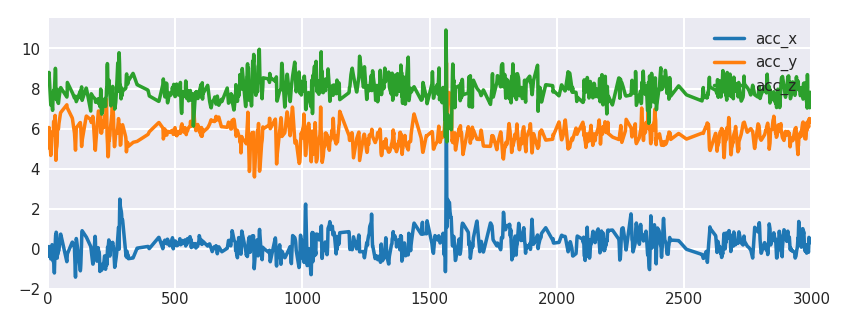

After Scaling:


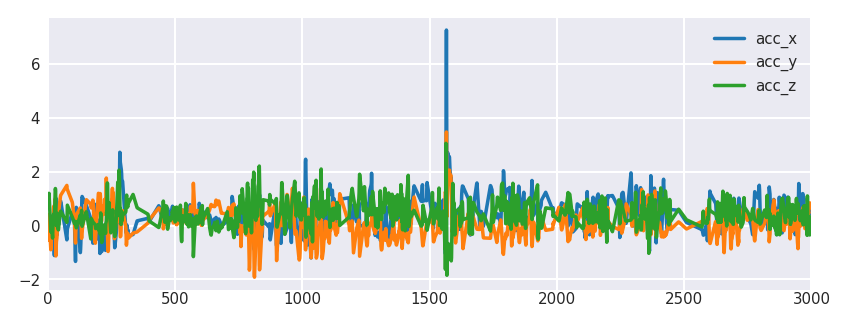

Validation Data:
Before Scaling:


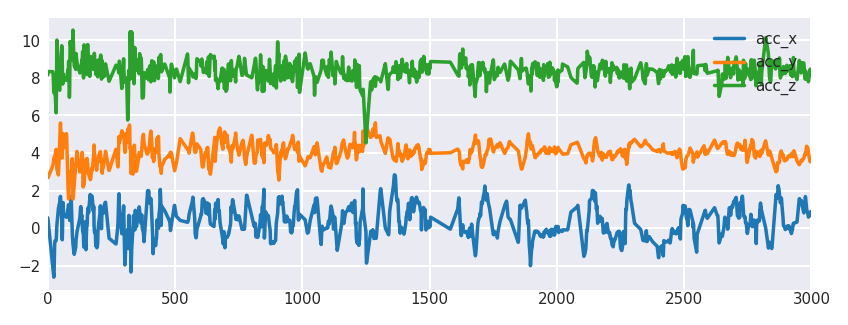

After Scaling:


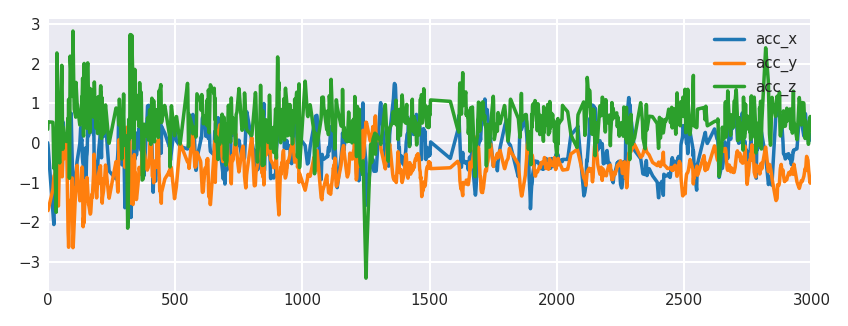

In [15]:
if not P.scaler_global:
    print("Scaling Data for Siamese Network only...")
    print("Training Data:")
    hmog.valid_train, _ = utils_custom_scale(
        hmog.valid_train,
        scale_cols=P.feature_cols,
        feature_cols=P.feature_cols,
        scaler_name=P.scaler,
        scope=P.scaler_scope,
        plot=True,        
    )
    print("Validation Data:")
    hmog.valid_test, _ = utils_custom_scale(
        hmog.valid_test,
        scale_cols=P.feature_cols,        
        feature_cols=P.feature_cols,
        scaler_name=P.scaler,
        scope=P.scaler_scope,
        plot=True,        
    )
else:
    print("Skipped, already normalized.")    

### 2.5 Check Splits <a id='2.5'>&nbsp;</a> 

In [16]:
utils_split_report(hmog.valid_train)

Unique subjects: 4
Unique sessions: 48

Head:


,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,mag_x,mag_y,mag_z,subject,session,task_type
0,-0.087220,-0.552028,0.856074,-0.077475,-0.044569,-0.019363,-27.751167,15.160111,-2.113555,579284,579284_session_1,4
1,-0.243804,-0.261379,0.690688,0.021356,0.016582,-0.022128,-28.052944,14.979074,-2.555037,579284,579284_session_1,4
2,-0.240554,-0.004920,0.877820,0.120188,0.077733,-0.024893,-28.354722,14.798037,-2.996518,579284,579284_session_1,4
3,0.016995,0.018300,0.789253,0.219019,0.138883,-0.027658,-28.656500,14.617000,-3.437999,579284,579284_session_1,4
4,0.188349,0.208645,0.959635,0.317851,0.200034,-0.030423,-28.958277,14.435963,-3.879481,579284,579284_session_1,4




Sessions' Task Types per subject:


subject,326223,538363,579284,621276
2,4,4,4,4
4,4,4,4,4
6,4,4,4,4


In [17]:
utils_split_report(hmog.valid_test)

Unique subjects: 1
Unique sessions: 12

Head:


,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,mag_x,mag_y,mag_z,subject,session,task_type
0,0.005691,-1.691680,0.346385,1.483116,-0.146439,-0.277330,-14.219101,-12.695351,-25.110316,863985,863985_session_1,4
1,-0.053653,-1.702157,0.521470,1.380316,-0.093861,-0.209721,-13.827368,-12.376284,-25.332494,863985,863985_session_1,4
2,-0.139472,-1.677118,0.534387,1.277516,-0.041283,-0.142111,-13.435634,-12.057217,-25.554672,863985,863985_session_1,4
3,-0.227497,-1.649120,0.533790,1.174716,0.011295,-0.074501,-13.043901,-11.738151,-25.776850,863985,863985_session_1,4
4,-0.315522,-1.621121,0.533193,1.071916,0.063873,-0.006892,-12.652167,-11.419084,-25.999027,863985,863985_session_1,4




Sessions' Task Types per subject:


subject,863985
2,4
4,4
6,4


In [18]:
utils_split_report(hmog.test_train)

Unique subjects: 1
Unique sessions: 12

Head:


,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,mag_x,mag_y,mag_z,subject,session,task_type
0,0.099382,6.780607,5.686733,-0.122020,-0.067959,-0.192728,2.450000,-35.971874,-27.142000,913228,913228_session_10,2
1,0.168844,6.705050,5.695278,-0.037893,-0.178587,-0.176568,2.553653,-35.900816,-27.092969,913228,913228_session_10,2
2,0.237525,6.624257,5.704385,-0.049652,-0.223401,-0.200069,2.581898,-36.118123,-27.014520,913228,913228_session_10,2
3,0.306206,6.543465,5.713493,-0.061411,-0.268214,-0.223570,2.610143,-36.335429,-26.936071,913228,913228_session_10,2
4,0.374886,6.462672,5.722600,-0.073170,-0.313028,-0.247072,2.638388,-36.552735,-26.857622,913228,913228_session_10,2




Sessions' Task Types per subject:


subject,913228
2,4
4,4
6,4


In [19]:
utils_split_report(hmog.test_test)

Unique subjects: 3
Unique sessions: 36

Head:


,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,mag_x,mag_y,mag_z,subject,session,task_type
0,-1.656289,2.911100,9.107593,1.280081,1.351130,1.173459,9.418839,21.752000,3.928839,220962,220962_session_11,4
1,-1.667728,2.918415,9.166783,0.644309,1.182558,0.872620,10.034030,20.695000,4.320530,220962,220962_session_11,4
2,-1.679167,2.925731,9.225973,-0.041081,0.998688,0.545740,10.214500,20.695000,4.657001,220962,220962_session_11,4
3,-1.690606,2.933047,9.285163,-0.726471,0.814818,0.218860,10.394971,20.695000,4.993471,220962,220962_session_11,4
4,-1.702045,2.940362,9.344353,-1.411860,0.630948,-0.108020,10.574328,20.730629,5.308912,220962,220962_session_11,4




Sessions' Task Types per subject:


subject,220962,396697,675397
2,4,4,4
4,4,4,4
6,4,4,4


### 2.6 Reshape Features  <a id='2.6'>&nbsp;</a> 

**Reshape & cache Set for Training Siamese Network:**

In [21]:
df_siamese_train = utils_reshape_features(
    hmog.valid_train,
    feature_cols=P.feature_cols,
    window_size=P.window_size,
    step_width=P.step_width,
)

# Clean memory
#del hmog.train
#%reset_selective -f hmog.train

print("Validation data after reshaping:")
display(df_siamese_train.head())

# Store iterim data
#df_siamese_train.to_msgpack(OUTPUT_PATH / "df_siamese_train.msg")
df_siamese_train.to_parquet('df_siamese_train.parquet.gzip',compression='gzip') 

# Clean memory
%reset_selective -f df_siamese_train

Validation data after reshaping:


,X,subject,session,task_type
0,"[[-0.3140159266809338, -0.030662052943453002, ...",326223,326223_session_1,6
1,"[[0.22493398721581895, -0.5365488785402647, 0....",326223,326223_session_1,6
2,"[[-1.6474706271372588, -0.16910334657871942, -...",326223,326223_session_1,6
3,"[[0.0755299132960448, 0.19274095517445353, -0....",326223,326223_session_1,6
4,"[[0.013535064360445792, 0.11791750456454221, -...",326223,326223_session_1,6


**Reshape & cache Set for Validating Siamese Network:** (also used to optimize OCSVM)

In [22]:
df_siamese_valid = utils_reshape_features(
    hmog.valid_test,
    feature_cols=P.feature_cols,
    window_size=P.window_size,
    step_width=P.step_width,
)

del hmog.valid
%reset_selective -f hmog.valid

print("Testing data after reshaping:")
display(df_siamese_valid.head())

# Store iterim data
#df_siamese_valid.to_msgpack(OUTPUT_PATH / "df_siamese_valid.msg")
df_siamese_valid.to_parquet('df_siamese_valid.parquet.gzip',compression='gzip') 

# Clean memory
%reset_selective -f df_siamese_valid

Testing data after reshaping:


,X,subject,session,task_type
0,"[[0.005691054010759006, -1.6916796380130485, 0...",863985,863985_session_1,4
1,"[[-0.05761786795254269, -1.3738875100254715, 0...",863985,863985_session_1,4
2,"[[-0.7721341506839173, -1.0838558723664153, 0....",863985,863985_session_1,4
3,"[[-0.4754876778736294, 0.15733684050289817, -0...",863985,863985_session_1,4
4,"[[0.3389690520678466, -1.3216184365452766, 0.3...",863985,863985_session_1,4


**Reshape & cache Set for Training/Validation OCSVM:**

In [23]:
df_ocsvm_train_valid = utils_reshape_features(
    hmog.test_train,
    feature_cols=P.feature_cols,
    window_size=P.window_size,
    step_width=P.step_width,
)

del hmog.test_train
%reset_selective -f hmog.test_train

print("Testing data after reshaping:")
display(df_ocsvm_train_valid.head())

# Store iterim data
#df_ocsvm_train_valid.to_msgpack(OUTPUT_PATH / "df_ocsvm_train_valid.msg")
df_ocsvm_train_valid.to_parquet('df_ocsvm_train_valid.parquet.gzip',compression='gzip')

# Clean memory
%reset_selective -f df_ocsvm_train_valid

Testing data after reshaping:


,X,subject,session,task_type
0,"[[0.09938241748921309, 6.7806074578339866, 5.6...",913228,913228_session_10,2
1,"[[-1.4975767426381965, 4.370154254822879, 7.42...",913228,913228_session_10,2
2,"[[-0.6207209578630872, 5.871204933343471, 6.50...",913228,913228_session_10,2
3,"[[-0.2907007541140527, 4.7420626154043966, 8.5...",913228,913228_session_10,2
4,"[[0.19050295951417412, 4.896432294316865, 7.58...",913228,913228_session_10,2


**Reshape & cache Set for Training/Testing OCSVM:**

In [24]:
df_ocsvm_train_test = utils_reshape_features(
    hmog.test_test,
    feature_cols=P.feature_cols,
    window_size=P.window_size,
    step_width=P.step_width,
)

del hmog.test_test
%reset_selective -f hmog.test_test

print("Testing data after reshaping:")
display(df_ocsvm_train_test.head())

# Store iterim data
#df_ocsvm_train_test.to_msgpack(OUTPUT_PATH / "df_ocsvm_train_test.msg")

df_ocsvm_train_test.to_parquet('df_ocsvm_train_test.parquet.gzip',compression='gzip')

# Clean memory
%reset_selective -f df_ocsvm_train_test
%reset_selective -f df_

Testing data after reshaping:


,X,subject,session,task_type
0,"[[-1.6562887125000003, 2.9110997625, 9.1075932...",220962,220962_session_11,4
1,"[[6.506063556585327, -0.9355338502341114, 7.57...",220962,220962_session_11,4
2,"[[1.925739229866161, 0.17324507296863026, 9.10...",220962,220962_session_11,4
3,"[[3.540076652887364, -1.2548110219707334, 8.64...",220962,220962_session_11,4
4,"[[3.161760990909091, 1.3153961590909091, 9.921...",220962,220962_session_11,4


## 3. Generate Scenario Pairs <a id='3'>&nbsp;</a> 

### 3.1 Load cached Data <a id='3.1'>&nbsp;</a> 

In [25]:
#df_siamese_train = pd.read_msgpack(OUTPUT_PATH / "df_siamese_train.msg")
#df_siamese_valid = pd.read_msgpack(OUTPUT_PATH / "df_siamese_valid.msg")

df_siamese_train = pd.read_parquet('df_siamese_train.parquet.gzip') 
df_siamese_valid = pd.read_parquet('df_siamese_valid.parquet.gzip') 

### 3.2 Build positive/negative Pairs  <a id='3.2'>&nbsp;</a> 

In [26]:
def build_pairs(df):
    # Limit samples per subject to sample of shortest session
    df = df.groupby("session", group_keys=False).apply(
        lambda x: x.sample(min(len(x), P.max_pairs_per_session), random_state=SEED)
    )
    df_pairs = None

    # Split samples subject wise 50:50
    # ---------------
    df_positives = None
    df_negatives = None

    for subject in df["subject"].unique():
        # Shuffle
        df_subj = df[df["subject"] == subject].sample(frac=1, random_state=SEED)

        # Make rows even
        if len(df_subj) % 2 != 0:
            df_subj = df_subj.iloc[:-1]

        half = len(df_subj) // 2

        df_positives = pd.concat([df_positives, df_subj.iloc[:half]])
        df_negatives = pd.concat([df_negatives, df_subj.iloc[half:]])

    # Positive Pairs
    # ---------------
    df_positive_left = None
    df_positive_right = None

    for subject in df_positives["subject"].unique():
        df_subj = df[df["subject"] == subject]
        # Make rows even
        if len(df_subj) % 2 != 0:
            df_subj = df_subj.iloc[:-1]

        # Split in half
        half = len(df_subj) // 2
        df_positive_left = pd.concat([df_positive_left, df_subj.iloc[:half]])
        df_positive_right = pd.concat([df_positive_right, df_subj.iloc[half:]])

    df_positive_left = df_positive_left.reset_index(drop=True)
    df_positive_right = df_positive_right.reset_index(drop=True)
    df_positive_left.columns = ["left_" + c for c in df_positive_left.columns]
    df_positive_right.columns = ["right_" + c for c in df_positive_right.columns]

    df_positives = pd.concat(
        [df_positive_left, df_positive_right],
        axis=1,
        sort=False,
        join_axes=[df_positive_left.index],
    )

    # Negative Pairs
    # ---------------
    # Make rows even
    if len(df_negatives) % 2 != 0:
        df_negatives = df_negatives.iloc[:-1]

    # Split in half
    half = len(df_negatives) // 2
    df_negative_left = df_negatives.iloc[half:].reset_index(drop=True)
    df_negative_right = df_negatives.iloc[:half].reset_index(drop=True)

    # Name columns
    df_negative_left.columns = ["left_" + c for c in df_negative_left.columns]
    df_negative_right.columns = ["right_" + c for c in df_negative_right.columns]

    # Combine
    df_negatives = pd.concat(
        [df_negative_left, df_negative_right],
        axis=1,
        sort=False,
        join_axes=[df_negative_left.index],
    )

    # Combine both Pairs
    # ---------------
    # Balance pairs
    min_len = min(len(df_positives), len(df_negatives))
    df_positives = df_positives.sample(n=min_len, random_state=SEED)
    df_negatives = df_negatives.sample(n=min_len, random_state=SEED)

    # Combine
    df_pairs = pd.concat([df_positives, df_negatives], sort=False)

    # Shuffle
    df_pairs = df_pairs.sample(frac=1, random_state=SEED).reset_index(drop=True)

    # Set Label
    df_pairs["label"] = np.where(
        df_pairs["left_subject"] == df_pairs["right_subject"], 1, 0
    )

    return df_pairs

In [27]:
# Reduce observations/samples per
print("Sample per session before reduction:\n ")
display(df_siamese_train["session"].value_counts().head(3))
display(df_siamese_valid["session"].value_counts().head(3))

df_siamese_train = df_siamese_train.groupby("session", group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), P.samples_per_subject_train), random_state=SEED)
)

df_siamese_valid = df_siamese_valid.groupby("session", group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), P.samples_per_subject_test), random_state=SEED)
)

print("\n\nSample per session after reduction:\n")
display(df_siamese_train["session"].value_counts().head(3))
display(df_siamese_valid["session"].value_counts().head(3))

Sample per session before reduction:
 


621276_session_1    286
621276_session_9    245
579284_session_3    205
Name: session, dtype: int64

863985_session_1     171
863985_session_13    130
863985_session_17    117
Name: session, dtype: int64



Sample per session after reduction:



621276_session_11    120
621276_session_2     120
579284_session_1     120
Name: session, dtype: int64

863985_session_1     120
863985_session_13    120
863985_session_17    117
Name: session, dtype: int64

In [28]:
df_siamese_train_pairs = build_pairs(df_siamese_train)
df_siamese_valid_pairs = build_pairs(df_siamese_valid)

### 3.3 Inspect Pairs <a id='3.3'>&nbsp;</a> 

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2496 entries, 0 to 2495
Data columns (total 9 columns):
left_X             2496 non-null object
left_subject       2496 non-null object
left_session       2496 non-null object
left_task_type     2496 non-null int64
right_X            2496 non-null object
right_subject      2496 non-null object
right_session      2496 non-null object
right_task_type    2496 non-null int64
label              2496 non-null int64
dtypes: int64(3), object(6)
memory usage: 175.6+ KB


None



Head:


,left_X,left_subject,left_session,left_task_type,right_X,right_subject,right_session,right_task_type,label
0,"[[-0.40804360324783473, 1.4743651238623097, -0...",579284,579284_session_15,2,"[[1.1515443850116662, -0.39412385208405815, -0...",579284,579284_session_5,2,1
1,"[[-0.25868603920634725, 0.21324111081756722, -...",538363,538363_session_24,6,"[[-1.454461219361541, 0.2610688192914961, -0.1...",538363,538363_session_9,2,1
2,"[[-0.8238346508253178, -0.22992444137207366, 0...",621276,621276_session_9,4,"[[0.7479060345082706, -0.6285493696424529, 0.2...",538363,538363_session_5,4,0
3,"[[0.3723013267557476, -0.5875598805666664, 0.4...",326223,326223_session_19,4,"[[-0.038941680931756636, 0.6048408062469061, -...",326223,326223_session_5,6,1
4,"[[0.27685141292107135, -0.5844267361282741, 0....",621276,621276_session_13,2,"[[0.5865177774380806, 0.24274438749309943, -0....",621276,621276_session_24,6,1




Any NaN values?


left_X             0
left_subject       0
left_session       0
left_task_type     0
right_X            0
right_subject      0
right_session      0
right_task_type    0
label              0
dtype: int64




Distribution of Samples per Subjects in training Data


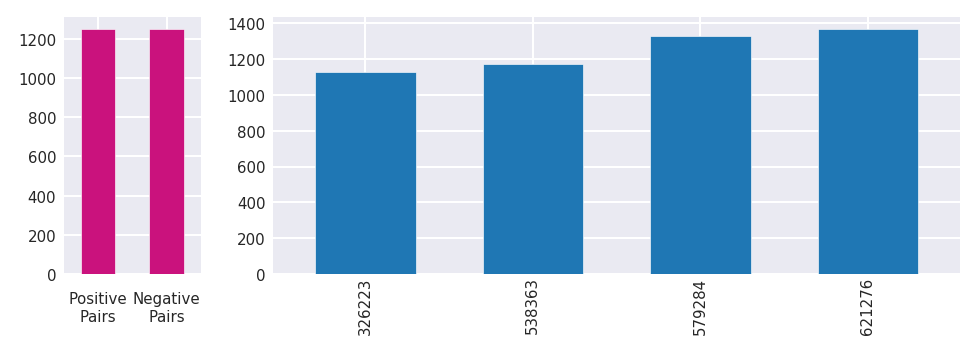

In [29]:
print("DataFrame Info:")
display(df_siamese_train_pairs.info())

print("\n\nHead:")
display(df_siamese_train_pairs.head(5))

print("\n\nAny NaN values?")
display(df_siamese_train_pairs.isnull().sum(axis = 0))

df_left_sub = df_siamese_train_pairs.groupby("left_subject")["left_subject"].count()
df_right_sub = df_siamese_train_pairs.groupby("right_subject")["right_subject"].count()
df_temp = pd.concat([df_left_sub, df_right_sub])

print("\n\n\nDistribution of Samples per Subjects in training Data")

fig, axes = plt.subplots(
    ncols=2, nrows=1, figsize=(5.473, 2), dpi=180, gridspec_kw={"width_ratios": [1, 5]}
)
df_siamese_train_pairs["label"].value_counts().rename(
    index={0: "Negative\nPairs", 1: "Positive\nPairs"}
).plot.bar(ax=axes[0], rot=0, color=MAGENTA)
axes[0].tick_params(axis="x", which="major", pad=7)
df_temp.groupby(df_temp.index).sum().plot.bar(ax=axes[1], width=0.6)
fig.tight_layout()

utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-pair-dist.pdf")

### 3.4 Cache Pairs <a id='3.4'>&nbsp;</a> 

In [30]:
#df_siamese_train_pairs.to_msgpack(OUTPUT_PATH / "df_siamese_train_pairs.msg")
#df_siamese_valid_pairs.to_msgpack(OUTPUT_PATH / "df_siamese_valid_pairs.msg")#


df_siamese_train_pairs.to_parquet('df_siamese_train_pairs.parquet.gzip',compression='gzip')
df_siamese_valid_pairs.to_parquet('df_siamese_valid_pairs.parquet.gzip',compression='gzip')

In [31]:
# Clean Memory
#%reset_selective -f df_

## 4. Siamese Network <a id='4'>&nbsp;</a> 

### 4.1 Load cached Pairs <a id='4.1'>&nbsp;</a> 

In [32]:
#df_siamese_train_pairs = pd.read_msgpack(OUTPUT_PATH / "df_siamese_train_pairs.msg")
#df_siamese_valid_pairs = pd.read_msgpack(OUTPUT_PATH / "df_siamese_valid_pairs.msg")
df_siamese_valid_pairs = pd.read_parquet('df_siamese_valid_pairs.parquet.gzip') 
df_siamese_train_pairs = pd.read_parquet('df_siamese_train_pairs.parquet.gzip') 

### 4.2 Build Model <a id='4.2'>&nbsp;</a> 

#### Distance Function

In [33]:
def k_euclidean_dist(t):
    x = t[0]
    y = t[1]    
    return K.sqrt(K.sum(K.square(x - y), axis=-1, keepdims=True))

#### Loss Function

In [34]:
def k_contrastive_loss(y_true, dist):
    """Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """
    margin = P.margin
    return K.mean(y_true * K.square(dist) + (1 - y_true) * K.square(K.maximum(margin - dist, 0)))

Sanity check contrastive loss function:

In [35]:
def contrastive_loss_test(y_true, dist):
    """Test function above using implementation with numpy instead tensors."""
    margin = P.margin
    return y_true * np.square(dist) + (1 - y_true) * np.square(np.max(margin - dist, 0))

In [36]:
print("Positive: class=1, distance=0,     loss:", contrastive_loss_test(1, 0))
print("Positive: class=1, distance=0.01,  loss:", contrastive_loss_test(1, 0.01))
print("Positive: class=1, distance=0.3,   loss:", contrastive_loss_test(1, 0.3))
print("Positive: class=1, distance=0.5,   loss:", contrastive_loss_test(1, 0.5))
print("Positive: class=1, distance=1,     loss:", contrastive_loss_test(1, 1))

Positive: class=1, distance=0,     loss: 0
Positive: class=1, distance=0.01,  loss: 0.0001
Positive: class=1, distance=0.3,   loss: 0.09
Positive: class=1, distance=0.5,   loss: 0.25
Positive: class=1, distance=1,     loss: 1


In [37]:
print("Negative: class=0, distance=0,     loss:", contrastive_loss_test(0, 0))
print("Negative: class=0, distance=0.01,  loss:", contrastive_loss_test(0, 0.01))
print("Negative: class=0, distance=0.3,   loss:", contrastive_loss_test(0, 0.3))
print("Negative: class=0, distance=0.5,   loss:", contrastive_loss_test(0, 0.5))
print("Negative: class=0, distance=5,     loss:", contrastive_loss_test(0, 1))

Negative: class=0, distance=0,     loss: 1
Negative: class=0, distance=0.01,  loss: 0.9801
Negative: class=0, distance=0.3,   loss: 0.48999999999999994
Negative: class=0, distance=0.5,   loss: 0.25
Negative: class=0, distance=5,     loss: 0


#### Siamese Model with 2D Filters, as derived from Centeno et al. (2018)

In [38]:
def build_model_2d(input_shape, filters):
    """
        Siamese CNN architecture with 3D input and 2D filters
    """
    # Define the tensors for the two input images
    left_inputs = Input(input_shape, name="left_inputs")
    right_inputs = Input(input_shape, name="right_inputs")

    # Convolutional Neural Network
    inputs = Input(input_shape, name="input")
    x = Conv2D(filters[0], (7, 7), padding="same", activation="tanh", name="conv1")(inputs)
    x = MaxPooling2D(pool_size=(2, 2), padding="same", name="mp1")(x)
    x = Conv2D(filters[1], (5, 5), padding="same", activation="tanh", name="conv2")(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="same", name="mp2")(x)
    x = Conv2D(filters[2], (3, 3), padding="same", activation="tanh", name="conv3")(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="same", name="mp3")(x)
    x = Conv2D(filters[3], (3, 3), padding="same", activation="tanh", name="conv4")(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="same", name="mp4")(x)
    x = Flatten(name="flat")(x)
    
    # Basemodel instance
    basemodel = Model(inputs, x, name="basemodel")

    # using same instance of "basemodel" to share weights between left/right networks
    encoded_l = basemodel(left_inputs)
    encoded_r = basemodel(right_inputs)

    # Add a customized layer to compute the distance between the encodings
    distance_layer = Lambda(k_euclidean_dist, name="distance")([encoded_l, encoded_r])

    # Combine into one net
    siamese_net = Model(inputs=[left_inputs, right_inputs], outputs=distance_layer)

    # return the model
    return siamese_net, basemodel

#### Siamese Model with 1D Filters, similar than Centeno et al. (2018)

In [39]:
def build_model_1d(input_shape, filters):
    """
        Model architecture
    """
    # Define the tensors for the two input images
    left_inputs = Input(input_shape, name="left_inputs")
    right_inputs = Input(input_shape, name="right_inputs")

    # Convolutional Neural Network
    inputs = Input(input_shape, name="input")
    x = Conv1D(filters[0], 7, activation="elu", padding="same", name="conv1")(inputs)
    x = MaxPooling1D(pool_size=2, name="mp1")(x)
    x = Conv1D(filters[1], 5, activation="elu", padding="same", name="conv2")(x)
    x = MaxPooling1D(pool_size=2, name="mp2")(x)
    x = Conv1D(filters[2], 3, activation="elu", padding="same", name="conv3")(x)
    x = MaxPooling1D(pool_size=2, name="mp3")(x)
    x = Conv1D(filters[3], 3, activation="elu", padding="same", name="conv4")(x)
    x = MaxPooling1D(pool_size=2, name="mp5")(x)
    x = Flatten(name="flat")(x)

    # Generate the encodings (feature vectors) for the two images
    basemodel = Model(inputs, x, name="basemodel")

    # using same instance of "basemodel" to share weights between left/right networks
    encoded_l = basemodel(left_inputs)
    encoded_r = basemodel(right_inputs)

    # Add a customized layer to compute the absolute difference between the encodings
    distance_layer = Lambda(k_euclidean_dist, name="distance")([encoded_l, encoded_r])

    siamese_net = Model(inputs=[left_inputs, right_inputs], outputs=distance_layer)

    # return the model
    return siamese_net, basemodel

#### Siamese Model with FCN architecture

In [40]:
def build_model_fcn(input_shape, filters):
    # Define the tensors for the two input images
    print(input_shape)
    left_inputs = Input(input_shape, name="left_inputs")
    right_inputs = Input(input_shape, name="right_inputs")

    # Convolutional Neural Network
    inputs = Input(input_shape, name="input")
    x = Conv1D(
        filters=filters[0],
        kernel_size=8,
        strides=1,
        activation=None,
        padding="same",
        name="conv1",
    )(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.1, name="drop1")(x)
    x = Conv1D(
        filters=filters[1],
        kernel_size=5,
        strides=1,
        activation=None,
        padding="same",
        name="conv2",
    )(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.1, name="drop2")(x)
    x = Conv1D(
        filters=filters[2],
        kernel_size=3,
        strides=1,
        activation=None,
        padding="same",
        name="conv3",
    )(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(32, activation="sigmoid", name="dense")(x) # <--- !!!!!!!!!!!!

    # Basemodel instance
    basemodel = Model(inputs, x, name="basemodel")

    # using same instance of "basemodel" to share weights between left/right networks
    encoded_l = basemodel(left_inputs)
    encoded_r = basemodel(right_inputs)

    # Add a customized layer to compute the distance between the encodings
    distance_layer = Lambda(k_euclidean_dist, name="distance")([encoded_l, encoded_r])

    # Combine into one net
    siamese_net = Model(inputs=[left_inputs, right_inputs], outputs=distance_layer)

    # return the model
    return siamese_net, basemodel

In [41]:
def get_model(name, window_size, feature_cols, filters):
    print(f"Using Model variant {name}...")
    if name == "1d":
        model, basemodel = build_model_1d((window_size, len(feature_cols)), filters)
    elif name == "2d":
        model, basemodel = build_model_2d((window_size, len(feature_cols), 1), filters)
    elif name == "fcn":
        model, basemodel = build_model_fcn((window_size, len(feature_cols)), filters)
    else:
        raise BaseException("Error: Not a valid model name: {1d, 2d, fcn}")

    return model, basemodel

**Inspect model architecture:**

In [42]:
temp_model, temp_basemodel = get_model(P.model_variant, P.window_size, P.feature_cols, P.filters)

temp_basemodel.summary()
temp_model.summary()

Using Model variant fcn...
(125, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 125, 3)            0         
_________________________________________________________________
conv1 (Conv1D)               (None, 125, 32)           800       
_________________________________________________________________
batch_normalization_1 (Batch (None, 125, 32)           128       
_________________________________________________________________
activation_1 (Activation)    (None, 125, 32)           0         
_________________________________________________________________
drop1 (Dropout)              (None, 125, 32)           0         
_________________________________________________________________
conv2 (Conv1D)               (None, 125, 64)           10304     
_________________________________________________________________
batch_normalization_2 (Batch (None, 125,

### 4.3 Prepare Features <a id='4.3'>&nbsp;</a> 

In [43]:
def prep_X_y_pair(df):
    
    # @Iman
    # this is necessary to avoid creating an np.array of np.array's
    # instead of a 3D array
    X_left = np.array([np.stack(x) for x in np.stack(df["left_X"].values)])
    X_right = np.array([np.stack(x) for x in np.stack(df["right_X"].values)])
    
    # X_left = np.stack(list(df["left_X"].values))
    # X_right = np.stack(list(df["right_X"].values))
    
    X = [X_left, X_right]
    y = df["label"].values
    
    return X, y

In [44]:
X_train, y_train = prep_X_y_pair(df_siamese_train_pairs)
X_valid, y_valid = prep_X_y_pair(df_siamese_valid_pairs)

# 2D Filter Model needs flat 4th dimension
if P.model_variant == "2d":
    X_train[0] = X_train[0].reshape((*X_train[0].shape, 1))
    X_train[1] = X_train[1].reshape((*X_train[1].shape, 1))
    X_valid[0] = X_valid[0].reshape((*X_valid[0].shape, 1))
    X_valid[1] = X_valid[1].reshape((*X_valid[1].shape, 1))

print(
    f"Training samples:   {y_train.shape[0]}, shape: {X_train[0].shape},"
    + f" class balance: {np.unique(y_train, return_counts=True)}"
)
print(
    f"Validation samples: {y_valid.shape[0]}, shape: {X_valid[0].shape},"
    + f" class balance: {np.unique(y_valid, return_counts=True)}"
)

Training samples:   2496, shape: (2496, 125, 3), class balance: (array([0, 1]), array([1248, 1248]))
Validation samples: 578, shape: (578, 125, 3), class balance: (array([1]), array([578]))


### 4.4 Search optimal Epoch <a id='4.4'>&nbsp;</a> 

In [45]:
class MetricsCallback(Callback):
    """
    Custom Keras Callback function.
    
    Used to predict and plot distances for positive and negative pairs
    after each n-th epoch, along with some 'classification' metrics. 
    'Classification' here means to ability to distinguish between positive 
    and negative pairs using a threshold for the distance.
    
    Arguments:
        payload {tuple}           -- Datasets used for evaluation: (X_valid, y_valid, X_train, y_train)
        epoch_evaluate_freq {int} -- Frequency for evaluation. After every n-th epoch, 
                                     the results are evaluated and printed
        save_plots {boolean}      -- Do you want to save plots as PDF? Path is configured via global
                                     parameter REPORT_PATH.
    """

    def __init__(self, payload, epoch_evaluate_freq=1, save_plots=False):

        self.X_valid, self.y_valid, self.X_train, self.y_train = payload
        self.save_plots = save_plots
        self.epoch_evaluate_freq = epoch_evaluate_freq

        # Do we have train and valid set?
        self.sets = []
        if self.X_train:
            self.sets.append([self.X_train, self.y_train, "Train"])
        if self.X_valid:
            self.sets.append([self.X_valid, self.y_valid, "Valid"])

    def on_train_begin(self, logs={}):
        print(32 * "=" + f"[ Initial State ]" + 32 * "=", end="")
        for X, y, desc in self.sets:
            self.evaluate(X, y, logs, desc, -1)

    def on_train_end(self, logs={}):
        print(32 * "=" + f"[ Final State ]" + 32 * "=", end="")
        for X, y, desc in self.sets:
            self.evaluate(X, y, logs, desc, -1)

    def on_epoch_end(self, epoch, logs={}):
        print(32 * "=" + f"[   Epoch {epoch}   ]" + 32 * "=", end="")
        if epoch % self.epoch_evaluate_freq == 0:  # Evaluate only every n-th epoch
            for X, y, desc in self.sets:
                self.evaluate(X, y, logs, desc, epoch)
        else:
            print(f"\n{ ', '.join([k + ': ' + f'{v:.3f}' for k,v in logs.items()]) }")

    def evaluate(self, X, y, logs, desc, epoch):
        # Predict
        y_score = self.model.predict(X)
        y_score_neg = y_score * -1  # lower distance means closer to positive class

        # Calc Metrics
        roc_val = metrics.roc_auc_score(y, y_score_neg)
        eer_val, thres = utils_eer(y, y_score_neg, True)
        y_pred = np.where(y_score_neg > thres, 1, 0)
        acc_val = metrics.accuracy_score(y, y_pred)
        f1_val = metrics.f1_score(y, y_pred)

        print(
            f"\n{desc.upper()}: roc_auc: {roc_val:.4f}, "
            + f"eer: {eer_val:.4f}, thres: {thres*-1:.4f} => "
            + f"acc: {acc_val:.4f}, f1: {f1_val:.4f}\n"
            + f"{ ', '.join([k + ': ' + f'{v:.3f}' for k,v in logs.items()]) }"
        )

        # Plot distances
        mask = np.where(y == 1, True, False)
        dist_positive = y_score[mask]
        dist_negative = y_score[~mask]
        plt = utils_plot_distance_hist(
            dist_positive, dist_negative, thres * -1, desc=desc, margin=P.margin
        )

        if self.save_plots:
            utils_save_plot(
                plt,
                REPORT_PATH
                / f"buech2019-siamese-{P.name.lower()}-epoch-{epoch+1}-{desc.lower()}.pdf",
            )

        plt.show()

In [46]:
def get_optimizer(name, lr=None, decay=None):
    if name == "sgd":
        lr = lr if lr != None else 0.01
        decay = decay if decay != None else 0
        optimizer = SGD(lr=lr, decay=decay)
    elif name == "adam":
        lr = lr if lr != None else 0.001
        decay = decay if decay != None else 0
        optimizer = Adam(lr=lr, decay=decay)
    elif name == "rmsprop":
        lr = lr if lr != None else 0.001
        optimizer = RMSprop(lr=lr)
    else:
        raise BaseException("Error: Not a valid model name: 1d or 2d.")
    return optimizer

Using Model variant fcn...
(125, 3)
Train on 2496 samples, validate on 578 samples
================================[ Initial State ]================================
TRAIN: roc_auc: 0.4912, eer: 0.5060, thres: 0.0694 => acc: 0.4936, f1: 0.4936



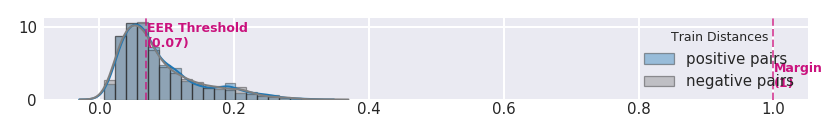

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [47]:
# Select model architecture
model, basemodel = get_model(P.model_variant, P.window_size, P.feature_cols, P.filters)

# Select Optimizer
optimizer = get_optimizer(P.optimizer, P.optimizer_lr)

# Compile
warnings.filterwarnings("ignore")
model.compile(loss=k_contrastive_loss, optimizer=optimizer)

# Train
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=P.batch_size,
    epochs=P.epochs_max,
    verbose=1,
    validation_data=(X_valid, y_valid),
    callbacks=[MetricsCallback((X_valid, y_valid, X_train, y_train), epoch_evaluate_freq=5, save_plots=True)],
)

print("Training History:")
plt = utils_plot_training_loss(history)
utils_save_plot(
    plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-epoch-trainloss.pdf"
)
plt.show()

### 4.5 Check Distances <a id='4.5'>&nbsp;</a> 

In [ ]:
# Predic validation set
dists = model.predict(X_valid)

# Stats
print(f"Mean distance: {dists.mean():.5f}")
print(f"Max distance: {dists.max():.5f}")
print(f"Min distance: {dists.min():.5f}\n")

# Histrogram
print("\nHistogram of Pair Distances:")
eer_val, thres = utils_eer(y_valid, dists, True)
mask = np.where(y_valid == 1, True, False)
dist_positive = dists[mask]
dist_negative = dists[~mask]
plt = utils_plot_distance_hist(dist_positive, dist_negative, thres, "Valid")
plt.show()

### 4.6 Rebuild and train to optimal Epoch  <a id='4.6'>&nbsp;</a> 
Now, that we know the learning curve, we can rebuild the model and train it until the best Epoch.

Also, we will include the validation data to have more training data. 

**Note:** This also means, that the training metrics are not valid anymore, because we don't have any validation data left to test against...

In [ ]:
# Concat train & valid data
X_train_valid = [[], []]
X_train_valid[0] = np.vstack([X_train[0], X_valid[0]])
X_train_valid[1] = np.vstack([X_train[1], X_valid[1]])
y_train_valid = np.hstack([y_train, y_valid])

# Select model architecture
model, basemodel = get_model(P.model_variant, P.window_size, P.feature_cols, P.filters)

# Select Optimizer
optimizer = get_optimizer(P.optimizer, P.optimizer_lr)
    
# Compile
model.compile(loss=k_contrastive_loss, optimizer=optimizer)

# Train
history = model.fit(
    x=X_train_valid,
    y=y_train_valid,
    batch_size=P.batch_size,
    epochs=P.epochs_best,
    verbose=0,
    callbacks=[MetricsCallback((None, None, X_train, y_train), epoch_evaluate_freq=10, save_plots=False)],
)

### 4.7 Cache model <a id='4.7'>&nbsp;</a> 

In [ ]:
model.save(str((OUTPUT_PATH / f"{P.name}_model.h5").resolve()))

In [ ]:
# Clean Memory
#%reset_selective -f df_
#%reset_selective -f X_
#%reset_selective -f y_

## 5. Visualize Deep Features <a id='5'>&nbsp;</a> 

### 5.1 Load cached Data <a id='5.1'>&nbsp;</a> 

In [ ]:
#df_siamese_valid = pd.read_msgpack(OUTPUT_PATH / "df_siamese_valid.msg")
#df_siamese_train = pd.read_msgpack(OUTPUT_PATH / "df_siamese_train.msg")
#df_ocsvm_train_valid = pd.read_msgpack(OUTPUT_PATH / "df_ocsvm_train_valid.msg")


df_siamese_valid = pd.read_parquet('df_siamese_valid.parquet.gzip') 
df_siamese_train = pd.read_parquet('df_siamese_train.parquet.gzip') 
df_ocsvm_train_valid = pd.read_parquet('df_ocsvm_train_valid.parquet.gzip') 

### 5.2 Extract CNN from Siamese Model <a id='5.2'>&nbsp;</a> 
I do this by redirecting inputs and outputs.

However, the network still needs a pair as input (I wasn't able to change this). This slows down a little bit the prediction (as the input is predicted twice), but doesn't change the results.

In [ ]:
def load_deep_feature_model(model_path):
    # Copy of function from above. It's just more convenient for partially 
    # executing the notebook.
    def k_contrastive_loss(y_true, dist):
        """Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        """
        margin = P.margin
        return K.mean(
            y_true * K.square(dist)
            + (1 - y_true) * K.square(K.maximum(margin - dist, 0))
        )
    
    # Load Trained Siamese Network
    model = load_model(
        str(model_path.resolve()),
        custom_objects={"k_contrastive_loss": k_contrastive_loss},
    )

    # Extract one of the child networks
    deep_feature_model = Model(
        inputs=model.get_input_at(0),  # get_layer("left_inputs").input,
        outputs=model.get_layer("basemodel").get_output_at(1),
    )
    
    return deep_feature_model

In [ ]:
deep_feature_model = load_deep_feature_model(OUTPUT_PATH / f"{P.name}_model.h5")
deep_feature_model.summary()

### 5.3 Test Generation of Deep Features <a id='5.3'>&nbsp;</a> 

In [ ]:
def prep_X_y_single(df):
    X = np.stack(list(df["X"].values))
    y = df["label"].values
    return X, y

In [ ]:
def transform_to_sample_by_subject(df):
    sample_by_subject = []
    df["label"] = 1
    for subj in df["subject"].unique():
        df_subj = df[df["subject"] == subj]
        X_sub, y_sub = prep_X_y_single(df_subj)
        sample_by_subject.append((X_sub, y_sub, subj))
    return sample_by_subject

#### Select subset (for plotting) and transform features

In [ ]:
# Concat Valid & Train (both were used for last Training)
df_train_temp = pd.concat([df_siamese_valid, df_siamese_train])
df_test_temp = df_ocsvm_train_valid

# Select data from 20 subjects of the TRAINING SET
random.seed(SEED)
ten_subjects = random.sample(df_train_temp["subject"].unique().tolist(), 20)
df_train_temp = df_train_temp[df_train_temp["subject"].isin(ten_subjects)].copy()
df_train_temp = df_train_temp.groupby("subject").apply(lambda x: x.sample(n=300, random_state=SEED))  # Plot only subset of samples

# Select data from 10 subjects of the TEST SET (not included in training)
random.seed(SEED)
ten_subjects = random.sample(df_test_temp["subject"].unique().tolist(), 10)
df_test_temp = df_test_temp[df_ocsvm_train_valid["subject"].isin(ten_subjects)].copy()
df_test_temp = df_test_temp.groupby("subject").apply(lambda x: x.sample(n=300, random_state=SEED))  # Plot only subset of samples

# Transform Samples
samples_train = transform_to_sample_by_subject(df_train_temp)
samples_test = transform_to_sample_by_subject(df_test_temp)

print(f"First subject: {samples_train[0][2]}")
print(f"y shape: {samples_train[0][1].shape}")
print(f"X shape: {samples_train[0][0].shape}")

#### Predict Deep Features

In [ ]:
deep_features_train = None
for X, y, subj in samples_train:  
    if P.model_variant == "2d":
        X = X.reshape((*X.shape, 1))
    pred = deep_feature_model.predict([X, X])
    df_features = pd.DataFrame(pred)
    df_features["subject"] = subj
    deep_features_train = pd.concat([deep_features_train, df_features])
        
deep_features_test = None
for X, y, subj in samples_test:  
    if P.model_variant == "2d":
        X = X.reshape((*X.shape, 1))
    pred = deep_feature_model.predict([X, X])
    df_features = pd.DataFrame(pred)
    df_features["subject"] = subj
    deep_features_test = pd.concat([deep_features_test, df_features])
        
display(deep_features_train.head(3))
display(deep_features_test.head(3))

### 5.4 Visualize in 2D using PCA <a id='5.4'>&nbsp;</a> 

In [ ]:
def plot_pca(df):
    # PCA
    pca = PCA(n_components=2)
    deep_transformed = pca.fit_transform(df.drop(columns=["subject"]).values)

    # Create df with data needed for chart only
    df_viz = df.copy()
    df_viz["PCA0"] = deep_transformed[:, 0]
    df_viz["PCA1"] = deep_transformed[:, 1]
    df_viz.drop(
        columns=[c for c in df_viz.columns if c not in ["PCA0", "PCA1", "subject"]]
    )

    # Generate color index for every subject
    df_viz["Subject"] = pd.Categorical(df_viz["subject"])
    df_viz["colors"] = df_viz["Subject"].cat.codes

    if len(df_viz["Subject"].unique()) <= 10:
        pal = sns.color_palette("tab10")
    else:
        pal = sns.color_palette("tab20")
        
    # Actual plot
    fig = plt.figure(figsize=(5.473 / 1.5, 5.473 / 2), dpi=180)
    sns.scatterplot(
        x="PCA0",
        y="PCA1",
        data=df_viz,
        hue="Subject",
        legend="full",
        palette=pal,
        s=2,
        linewidth=0,
        alpha=0.6,
    )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize=5)
    fig.tight_layout()
    return plt

In [ ]:
plot_pca(deep_features_train)
utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-pca-train.pdf")

In [ ]:
plot_pca(deep_features_test)
utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-pca-test.pdf")

In [ ]:
### Cleanup memory
%reset_selective -f df_
%reset_selective -f X_
%reset_selective -f y_
%reset_selective -f pca

## 6. OCSVM <a id='6'>&nbsp;</a> 

### 6.1 Load cached Data <a id='6.1'>&nbsp;</a> 

In [ ]:
#df_ocsvm_train_valid = pd.read_msgpack(OUTPUT_PATH / "df_ocsvm_train_valid.msg")

df_ocsvm_train_valid = pd.read_parquet('df_ocsvm_train_valid.parquet.gzip') 

df_ocsvm_train_valid.head()

### 6.2 Load trained Siamese Model <a id='6.2'>&nbsp;</a> 

**Helper methods to load model:**

In [ ]:
def load_deep_feature_model(model_path):
    warnings.filterwarnings("ignore")  # Silence depr. warnings

    # Copy of function from above. It's just more convenient for partially executing the notebook.
    def k_contrastive_loss(y_true, dist):
        """Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        """
        margin = P.margin
        return K.mean(
            y_true * K.square(dist)
            + (1 - y_true) * K.square(K.maximum(margin - dist, 0))
        )

    # Load Trained Siamese Network
    model = load_model(
        str(model_path.resolve()),
        custom_objects={"k_contrastive_loss": k_contrastive_loss},
    )

    # Extract one of the child networks
    deep_feature_model = Model(
        inputs=model.get_input_at(0),  # get_layer("left_inputs").input,
        outputs=model.get_layer("basemodel").get_output_at(1),
    )

    return deep_feature_model

**Sanity Check:**

### 6.3 Search for Parameters <a id='6.3'>&nbsp;</a> 

In [ ]:
df_ocsvm_train_valid.head()

In [ ]:
param_dist = {"gamma": np.logspace(-3, 3), "nu": np.linspace(0.0001, 0.3)}

# Load Siamese CNN Model
deep_feature_model = load_deep_feature_model(OUTPUT_PATH / f"{P.name}_model.h5")

df_results = None  # Will be filled with randomsearch scores

for run in tqdm(range(3)):
    for df_cv_scenarios, owner, impostors in tqdm(
        utils_generate_cv_scenarios(
            df_ocsvm_train_valid,
            samples_per_subject_train=P.samples_per_subject_train,
            samples_per_subject_test=P.samples_per_subject_test,
            seed=SEED + run,
            scaler=P.scaler,
            scaler_global=P.scaler_global,
            scaler_scope=P.scaler_scope,
            deep_model=deep_feature_model,
            model_variant=P.model_variant,
            feature_cols=P.feature_cols,
        ),
        desc="Owner",
        total=df_ocsvm_train_valid["subject"].nunique(),
        leave=False,
    ):

        X = np.array(df_cv_scenarios["X"].values.tolist())
        y = df_cv_scenarios["label"].values

        train_valid_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)

        model = OneClassSVM(kernel="rbf")

        warnings.filterwarnings("ignore")
        random_search = RandomizedSearchCV(
            model,
            param_distributions=param_dist,
            cv=train_valid_cv,
            n_iter=80,
            n_jobs=CORES,
            refit=False,
            scoring={"eer": utils_eer_scorer, "accuracy": "accuracy"},
            verbose=0,
            return_train_score=False,
            iid=False,
            error_score=np.nan,
            random_state=SEED,
        )

        random_search.fit(X, y)

        df_report = utils_cv_report(random_search, owner, impostors)
        df_report["run"] = run
        df_results = pd.concat([df_results, df_report], sort=False)

df_results.to_csv(OUTPUT_PATH / f"{P.name}_random_search_results.csv", index=False)

### 6.4 Inspect Search Results <a id='6.4'>&nbsp;</a> 
**Raw Results & Stats:**

In [ ]:
df_results = pd.read_csv(OUTPUT_PATH / f"{P.name}_random_search_results.csv")
print("Best results for each owner:")

display(
    df_results[df_results["rank_test_eer"] <= 1][
        [
            "owner",
            "param_nu",
            "param_gamma",
            "rank_test_eer",
            "mean_test_eer",
            "std_test_eer",
            "mean_test_accuracy",
            "std_test_accuracy",
        ]
    ].sort_values("mean_test_eer").head(10)
)

print("\n\n\nMost relevant statistics:")
display(
    df_results[df_results["rank_test_eer"] <= 1][
        [
            "mean_fit_time",
            "param_nu",
            "param_gamma",
            "mean_test_accuracy",
            "std_test_accuracy",
            "mean_test_eer",
            "std_test_eer",
        ]
    ].describe()
)

**Plot parameters of top n of 30 results for every Owner:**

In [ ]:
utils_plot_randomsearch_results(df_results, 1)
utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-parameters.pdf")

## 7. Testing <a id='7'>&nbsp;</a> 

### 7.1 Load cached Data <a id='7.1'>&nbsp;</a> 
During testing, a split with different users than used for hyperparameter optimization is used:

In [ ]:
df_ocsvm_train_test = pd.read_msgpack(OUTPUT_PATH / "df_ocsvm_train_test.msg")

### 7.2 Evaluate Authentication Performance <a id='7.2'>&nbsp;</a> 
- Using Testing Split, Scenario Cross Validation, and multiple runs to lower impact of random session/sample selection.

In [ ]:
# Load Siamese CNN Model
deep_feature_model = load_deep_feature_model(OUTPUT_PATH / f"{P.name}_model.h5")

df_results = None  # Will be filled with cv scores
for i in tqdm(range(5), desc="Run", leave=False):  # Run whole test 5 times
    for df_cv_scenarios, owner, impostors in tqdm(
        utils_generate_cv_scenarios(
            df_ocsvm_train_test,
            samples_per_subject_train=P.samples_per_subject_train,
            samples_per_subject_test=P.samples_per_subject_test,
            seed=SEED,
            scaler=P.scaler,
            scaler_global=P.scaler_global,
            scaler_scope=P.scaler_scope,
            deep_model=deep_feature_model,
            model_variant=P.model_variant,
            feature_cols=P.feature_cols,
        ),
        desc="Owner",
        total=df_ocsvm_train_test["subject"].nunique(),
        leave=False,
    ):

        X = np.array(df_cv_scenarios["X"].values.tolist())
        y = df_cv_scenarios["label"].values

        train_test_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)

        model = OneClassSVM(kernel="rbf", nu=P.ocsvm_nu, gamma=P.ocsvm_gamma)

        warnings.filterwarnings("ignore")
        scores = cross_validate(
            model,
            X,
            y,
            cv=train_test_cv,
            scoring={"eer": utils_eer_scorer, "accuracy": "accuracy"},
            n_jobs=CORES,
            verbose=0,
            return_train_score=True,
        )
        df_score = pd.DataFrame(scores)
        df_score["owner"] = owner
        df_score["train_eer"] = df_score["train_eer"].abs()  # Revert scorer's signflip
        df_score["test_eer"] = df_score["test_eer"].abs()
        df_results = pd.concat([df_results, df_score], axis=0)

df_results.to_csv(OUTPUT_PATH / f"{P.name}_test_results.csv", index=False)
df_results.head()

**Load Results from "EER & Accuracy" evaluation & prepare for plotting:**

In [ ]:
df_results = pd.read_csv(OUTPUT_PATH / f"{P.name}_test_results.csv")
df_plot = df_results.rename(
    columns={"test_accuracy": "Test Accuracy", "test_eer": "Test EER", "owner": "Owner"}
).astype({"Owner": str})

**Plot Distribution of Accuracy per subject:**

In [ ]:
fig = utils_plot_acc_eer_dist(df_plot, "Test Accuracy")
utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-acc.pdf")

**Plot Distribution of EER per subject:**

In [ ]:
fig = utils_plot_acc_eer_dist(df_plot, "Test EER")
utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-eer.pdf")

### 7.3 Evaluate increasing Training Set Size (Training Delay) <a id='7.3'>&nbsp;</a> 

In [ ]:
training_set_sizes = [1, 2, 3, 4, 10, 30, 60, 90, 125, 175, 250, 375]  # In samples

deep_feature_model = load_deep_feature_model(OUTPUT_PATH / f"{P.name}_model.h5")

df_results = None  # Will be filled with cv scores
for i in tqdm(range(5), desc="Run", leave=False):  # Run whole test 5 times
    for n_train_samples in tqdm(training_set_sizes, desc="Train Size", leave=False):
        for df_cv_scenarios, owner, impostors in tqdm(
            utils_generate_cv_scenarios(
                df_ocsvm_train_test,
                samples_per_subject_train=P.samples_per_subject_train,
                samples_per_subject_test=P.samples_per_subject_test,
                limit_train_samples=n_train_samples,  # samples overall
                seed=SEED + i,
                scaler=P.scaler,
                scaler_global=P.scaler_global,
                scaler_scope=P.scaler_scope,
                deep_model=deep_feature_model,
                model_variant=P.model_variant,
                feature_cols=P.feature_cols,
            ),
            desc="Owner",
            total=df_ocsvm_train_test["subject"].nunique(),
            leave=False,
        ):
            X = np.array(df_cv_scenarios["X"].values.tolist())
            y = df_cv_scenarios["label"].values

            train_test_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)

            model = OneClassSVM(kernel="rbf", nu=P.ocsvm_nu, gamma=P.ocsvm_gamma)

            warnings.filterwarnings("ignore")
            scores = cross_validate(
                model,
                X,
                y,
                cv=train_test_cv,
                scoring={"eer": utils_eer_scorer},
                n_jobs=CORES,
                verbose=0,
                return_train_score=True,
            )
            df_score = pd.DataFrame(scores)
            df_score["owner"] = owner
            df_score["train_samples"] = n_train_samples
            df_score["train_eer"] = df_score[
                "train_eer"
            ].abs()  # Revert scorer's signflip
            df_score["test_eer"] = df_score["test_eer"].abs()
            df_results = pd.concat([df_results, df_score], axis=0)

df_results.to_csv(OUTPUT_PATH / f"{P.name}_train_delay_results.csv", index=False)
df_results.head()

**Load Results from "Training set size" evaluation & prepare for plotting:**

In [ ]:
df_results = pd.read_csv(OUTPUT_PATH / f"{P.name}_train_delay_results.csv")
df_plot = (
    df_results[["test_eer", "owner", "train_samples"]]
    .groupby(["owner", "train_samples"], as_index=False)
    .mean()
    .astype({"owner": "category"})
    .rename(
        columns={
            "test_eer": "Test EER",
            "owner": "Owner",
        }
    )
)
df_plot["Training Data in Seconds"] = df_plot["train_samples"] * P.window_size / P.frequency

**Plot EER with increasing number of training samples:**

In [ ]:
utils_plot_training_delay(df_plot)
utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-train-size.pdf")

### 7.4 Evaluate increasing Test Set Sizes (Detection Delay)<a id='7.4'>&nbsp;</a> 

In [ ]:
# Load Siamese CNN Model
deep_feature_model = load_deep_feature_model(OUTPUT_PATH / f"{P.name}_model.h5")

df_results = None  # Will be filled with cv scores
for i in tqdm(range(50), desc="Run", leave=False):  # Run whole test 5 times
    for df_cv_scenarios, owner, impostors in tqdm(
        utils_generate_cv_scenarios(
            df_ocsvm_train_test,
            samples_per_subject_train=P.samples_per_subject_train,
            samples_per_subject_test=P.samples_per_subject_test,
            limit_test_samples=1,  # Samples overall
            seed=SEED + i,
            scaler=P.scaler,
            scaler_global=P.scaler_global,
            scaler_scope=P.scaler_scope,
            deep_model=deep_feature_model,
            model_variant=P.model_variant,
            feature_cols=P.feature_cols,
        ),
        desc="Owner",
        total=df_ocsvm_train_test["subject"].nunique(),
        leave=False,
    ):
        X = np.array(df_cv_scenarios["X"].values.tolist())
        y = df_cv_scenarios["label"].values

        train_test_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)

        model = OneClassSVM(kernel="rbf", nu=P.ocsvm_nu, gamma=P.ocsvm_gamma)

        warnings.filterwarnings("ignore")
        scores = cross_validate(
            model,
            X,
            y,
            cv=train_test_cv,
            scoring={"eer": utils_eer_scorer},
            n_jobs=CORES,
            verbose=0,
            return_train_score=True,
        )
        df_score = pd.DataFrame(scores)
        df_score["owner"] = owner
        df_score["run"] = i
        df_score["train_eer"] = df_score["train_eer"].abs()  # Revert scorer's signflip
        df_score["test_eer"] = df_score["test_eer"].abs()
        df_results = pd.concat([df_results, df_score], axis=0)

df_results.to_csv(OUTPUT_PATH / f"{P.name}_detect_delay_results.csv", index=False)
df_results.head()

**Load Results from "Detection Delay" evaluation & prepare for plotting:**

In [ ]:
df_results = pd.read_csv(OUTPUT_PATH / f"{P.name}_detect_delay_results.csv")
df_results["owner"] = df_results["owner"].astype(str)
df_plot = df_results.copy()

**Plot Expanding Mean EER and confidence interval:**

In [ ]:
utils_plot_detect_delay(df_plot, factor=P.window_size / P.frequency, xlim=160)
utils_save_plot(
    plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-detection-delay.pdf"
)